In [222]:
import numpy as np
import pandas as pd
from scipy.signal import welch
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

In [223]:
patient_num = 2

eeg_task_path = f'../Data/Processed/sub0{patient_num}_binned_task.csv'
eeg_data = pd.read_csv(eeg_task_path)

In [224]:
selected_electrodes = [
    'O1', 'O2', 'Oz', 'POz', 'PO3', 'PO4', 'PO7', 'PO8',
    'F3', 'F4', 'Fz', 'F7', 'F8', 'AF3', 'AF4', 'AF7', 'AF8', 'Fpz',
    'T7', 'T8', 'Cz', 'Pz', 'FCz', 'CP1', 'CP2'
]

In [225]:
def preprocess_eeg_data(eeg_data, selected_electrodes, window_size=128, step_size=64):
    """
    Preprocess EEG data to extract sliding windows.
    
    Parameters:
    - eeg_data: DataFrame with EEG data where each cell is a string representation of a list of floats
    - selected_electrodes: List of electrode names to extract data from
    - window_size: Size of each sliding window (default 128)
    - step_size: Step size between consecutive windows (default 64)
    
    Returns:
    - X: Array of shape (n_samples, n_electrodes, n_time_steps, window_size)
    - y: Array of corresponding labels
    """
    # Drop the non-electrode columns
    eeg_data_filtered = eeg_data.drop(columns=['label'])
    
    # Prepare lists to store sequences and labels
    sequences = []
    labels = []

    for idx, row in eeg_data_filtered.iterrows():
        trial_data = []

        for electrode in selected_electrodes:
            # Convert the cell string to a list of floats
            signal = np.array(eval(row[electrode]))

            # Check if the signal length is less than the window size
            if len(signal) < window_size:
                continue

            # Extract sliding windows
            windows = []
            for start in range(0, len(signal) - window_size + 1, step_size):
                window = signal[start:start + window_size]

                # Normalize each window and store
                if len(window) == window_size:
                    window = (window - np.mean(window)) / np.std(window)
                    windows.append(window)
            
            # Add windows to trial data
            if len(windows) > 0:
                trial_data.append(np.array(windows))  # Shape: (n_time_steps, window_size)
        
        # Ensure we have data for all selected electrodes
        if len(trial_data) == len(selected_electrodes):
            trial_data = np.array(trial_data)  # Shape: (n_electrodes, n_time_steps, window_size)
            sequences.append(trial_data)

            # Extract the label
            label = 1 if row['label_type'] == 'social' else 0
            labels.append(label)
    
    # Convert lists to numpy arrays
    X = np.array(sequences)
    y = np.array(labels)
    
    print(f"Shape of X after preprocessing: {X.shape}")
    print(f"Shape of y after preprocessing: {y.shape}")
    return X, y

In [226]:
window_size = 128
step_size = 32

# Extract sequences
X, y = preprocess_eeg_data(eeg_data, selected_electrodes, window_size, step_size)

# Check the shapes of the final output
print("Final Shape of X:", X.shape)
print("Final Shape of y:", y.shape)

Shape of X after preprocessing: (319, 25, 29, 128)
Shape of y after preprocessing: (319,)
Final Shape of X: (319, 25, 29, 128)
Final Shape of y: (319,)


In [227]:
class EEGDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [228]:
dataset = EEGDataset(X, y)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [229]:
class EEG_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_rate=0.5):
        super(EEG_LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, 
                            num_layers=num_layers, batch_first=True, dropout=dropout_rate)
        self.bn = nn.BatchNorm1d(hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, x):
        batch_size, n_electrodes, n_time_steps, window_size = x.shape
        x = x.view(batch_size, n_time_steps, n_electrodes * window_size)
        lstm_out, (hn, _) = self.lstm(x)
        out = self.bn(hn[-1])
        out = self.dropout(out)
        out = self.fc(out)
        return out

In [230]:
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

In [231]:
def evaluate_model(model, val_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(y_batch.numpy())
    return accuracy_score(all_labels, all_preds)

In [232]:
def cross_validate(X, y, hyperparams, device='cuda'):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    best_score = 0
    best_params = None
    
    # Correctly calculate input_size using the number of electrodes and window size
    n_electrodes = X.shape[1]
    window_size = X.shape[3]
    input_size = n_electrodes * window_size  # Correctly calculated as 25 * 128 = 3200
    print(f"Corrected input_size: {input_size}")

    for hidden_size in hyperparams['hidden_size']:
        for num_layers in hyperparams['num_layers']:
            for dropout_rate in hyperparams['dropout_rate']:
                for lr in hyperparams['learning_rate']:
                    scores = []
                    
                    for train_idx, val_idx in skf.split(X, y):
                        X_train, X_val = X[train_idx], X[val_idx]
                        y_train, y_val = y[train_idx], y[val_idx]
                        
                        train_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train, dtype=torch.float32), 
                                                                       torch.tensor(y_train, dtype=torch.long))
                        val_dataset = torch.utils.data.TensorDataset(torch.tensor(X_val, dtype=torch.float32), 
                                                                     torch.tensor(y_val, dtype=torch.long))
                        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
                        val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
                        
                        # Initialize the model with the corrected input_size
                        model = EEG_LSTM(input_size=input_size, hidden_size=hidden_size, 
                                         num_layers=num_layers, output_size=2, dropout_rate=dropout_rate).to(device)
                        
                        criterion = nn.CrossEntropyLoss()
                        optimizer = optim.Adam(model.parameters(), lr=lr)
                        
                        train_model(model, train_loader, criterion, optimizer, device)
                        accuracy = evaluate_model(model, val_loader, device)
                        scores.append(accuracy)
                    
                    avg_score = np.mean(scores)
                    if avg_score > best_score:
                        best_score = avg_score
                        best_params = {
                            'hidden_size': hidden_size,
                            'num_layers': num_layers,
                            'dropout_rate': dropout_rate,
                            'learning_rate': lr
                        }
                    print(f"Params: {hidden_size}, {num_layers}, {dropout_rate}, {lr}, Score: {avg_score:.4f}")
    
    print(f"Best Hyperparameters: {best_params}, Best Score: {best_score:.4f}")
    return best_params

In [233]:
hyperparams = {
    'hidden_size': [32, 64, 128],
    'num_layers': [1, 2, 3],
    'dropout_rate': [0.3, 0.5],
    'learning_rate': [0.001, 0.0001]
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Check the shape of X before cross-validation
print(f"Shape of X: {X.shape}")

# Run cross-validation
best_params = cross_validate(X, y, hyperparams, device=device)

Shape of X: (319, 25, 29, 128)
Corrected input_size: 3200


c:\Users\omarh\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
c:\Users\omarh\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
c:\Users\omarh\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but

Params: 32, 1, 0.3, 0.001, Score: 0.5360


c:\Users\omarh\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
c:\Users\omarh\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
c:\Users\omarh\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but

Params: 32, 1, 0.3, 0.0001, Score: 0.4796


c:\Users\omarh\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
c:\Users\omarh\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
c:\Users\omarh\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but

Params: 32, 1, 0.5, 0.001, Score: 0.4575


c:\Users\omarh\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
c:\Users\omarh\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
c:\Users\omarh\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but

Params: 32, 1, 0.5, 0.0001, Score: 0.4730
Params: 32, 2, 0.3, 0.001, Score: 0.4859
Params: 32, 2, 0.3, 0.0001, Score: 0.5391
Params: 32, 2, 0.5, 0.001, Score: 0.5300
Params: 32, 2, 0.5, 0.0001, Score: 0.5142
Params: 32, 3, 0.3, 0.001, Score: 0.4984
Params: 32, 3, 0.3, 0.0001, Score: 0.4953
Params: 32, 3, 0.5, 0.001, Score: 0.4984
Params: 32, 3, 0.5, 0.0001, Score: 0.4984


c:\Users\omarh\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
c:\Users\omarh\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
c:\Users\omarh\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but

Params: 64, 1, 0.3, 0.001, Score: 0.5358


c:\Users\omarh\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
c:\Users\omarh\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
c:\Users\omarh\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but

Params: 64, 1, 0.3, 0.0001, Score: 0.4984


c:\Users\omarh\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
c:\Users\omarh\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
c:\Users\omarh\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but

Params: 64, 1, 0.5, 0.001, Score: 0.4139


c:\Users\omarh\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
c:\Users\omarh\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
c:\Users\omarh\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but

Params: 64, 1, 0.5, 0.0001, Score: 0.4640
Params: 64, 2, 0.3, 0.001, Score: 0.4765
Params: 64, 2, 0.3, 0.0001, Score: 0.4797
Params: 64, 2, 0.5, 0.001, Score: 0.4610
Params: 64, 2, 0.5, 0.0001, Score: 0.4921
Params: 64, 3, 0.3, 0.001, Score: 0.5075
Params: 64, 3, 0.3, 0.0001, Score: 0.5110
Params: 64, 3, 0.5, 0.001, Score: 0.5047
Params: 64, 3, 0.5, 0.0001, Score: 0.5109


c:\Users\omarh\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
c:\Users\omarh\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
c:\Users\omarh\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but

Params: 128, 1, 0.3, 0.001, Score: 0.5455


c:\Users\omarh\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
c:\Users\omarh\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
c:\Users\omarh\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but

Params: 128, 1, 0.3, 0.0001, Score: 0.5580


c:\Users\omarh\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
c:\Users\omarh\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
c:\Users\omarh\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but

Params: 128, 1, 0.5, 0.001, Score: 0.5077


c:\Users\omarh\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
c:\Users\omarh\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
c:\Users\omarh\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but

Params: 128, 1, 0.5, 0.0001, Score: 0.5173
Params: 128, 2, 0.3, 0.001, Score: 0.4764
Params: 128, 2, 0.3, 0.0001, Score: 0.4953
Params: 128, 2, 0.5, 0.001, Score: 0.5014
Params: 128, 2, 0.5, 0.0001, Score: 0.4763
Params: 128, 3, 0.3, 0.001, Score: 0.4765
Params: 128, 3, 0.3, 0.0001, Score: 0.5016
Params: 128, 3, 0.5, 0.001, Score: 0.5109
Params: 128, 3, 0.5, 0.0001, Score: 0.4890
Best Hyperparameters: {'hidden_size': 128, 'num_layers': 1, 'dropout_rate': 0.3, 'learning_rate': 0.0001}, Best Score: 0.5580


In [234]:
def visualize_lstm_hidden_states(model, X_sample):
    """
    Visualize the hidden states of an LSTM model for a given input sample.
    
    Parameters:
    - model: Trained LSTM model
    - X_sample: A single sample from the dataset (shape: n_electrodes, n_time_steps, window_size)
    """
    # Reshape the input to match LSTM expectations
    with torch.no_grad():
        # Convert to PyTorch tensor and move to device
        X_sample = torch.tensor(X_sample, dtype=torch.float32).unsqueeze(0).to(device)  # Shape: (1, 25, 15, 128)
        
        # Reshape to (batch_size, n_time_steps, n_features)
        batch_size, n_electrodes, n_time_steps, window_size = X_sample.shape
        X_sample = X_sample.view(batch_size, n_time_steps, n_electrodes * window_size)  # Shape: (1, 15, 3200)
        
        # Pass through the LSTM to get hidden states
        lstm_out, (hn, _) = model.lstm(X_sample)
        hidden_states = lstm_out.squeeze(0).cpu().numpy()  # Shape: (n_time_steps, hidden_size)
    
    # Plot hidden state activations over time
    plt.figure(figsize=(10, 6))
    plt.imshow(hidden_states.T, aspect='auto', cmap='viridis')
    plt.colorbar(label='Hidden State Activation')
    plt.xlabel('Time Steps')
    plt.ylabel('Hidden Units')
    plt.title('LSTM Hidden State Activations')
    plt.show()

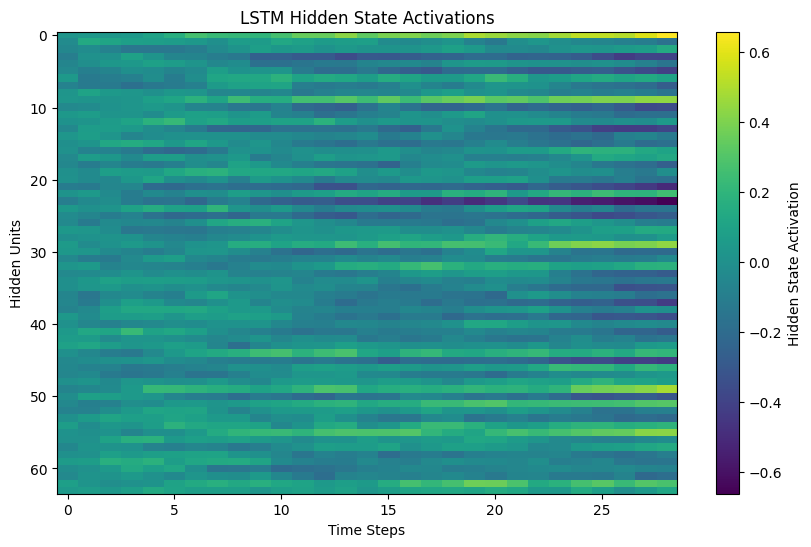

In [235]:
visualize_lstm_hidden_states(model, X[0])